In [132]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt

In [202]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
v_dir = '/pscratch/sd/j/jjpim/massmag/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

#new colum in tf mastertable
tf_mastertable['M_STELLAR_CEGALE']=np.nan
tf_mastertable['M_STELLAR_CEGALE_ERR']=np.nan
tf_mastertable['M_STELLAR_PROVABGS']=np.nan
tf_mastertable['M_STELLAR_PROVABGS_ERR']=np.nan

In [199]:
# read in first table
table = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits')
table[:5]

TARGETID,SURVEY,PROGRAM,HEALPIX,SPECTYPE,RA,DEC,RELEASE,Z,CHI2,LOGM,LOGM_ERR,LOGSFR,LOGSFR_ERR,AGNLUM,AGNFRAC,AGNPSY,LNU_U,LNU_G,LNU_R,LNU_I,LNU_Z,NUVR,RK,UV,VJ,GR,LNU_U_ERR,LNU_G_ERR,LNU_R_ERR,LNU_I_ERR,LNU_Z_ERR,NUVR_ERR,RK_ERR,UV_ERR,VJ_ERR,GR_ERR,FLAG_MASSPDF,FLAG_SFRPDF,FLAGOPTICAL,FLAGINFRARED,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,SNR_R,SNR_G,SNR_Z,SNR_W1,SNR_W2,SNR_W3,SNR_W4
,,,,,deg,deg,,,,log(solMass),log(solMass),log(solMass/yr),log(solMass/yr),W,,deg,W / Hz,W / Hz,W / Hz,W / Hz,W / Hz,mag,mag,mag,mag,mag,W / Hz,W / Hz,W / Hz,W / Hz,W / Hz,mag,mag,mag,mag,mag,,,,,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,,,,,,,,,,,,,,
int64,bytes7,bytes7,int32,bytes7,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
39627061832189859,sv1,bright,34721,GALAXY,59.188585396491234,-31.414421311684947,9010,0.19708479292210035,1.589095341412816,10.133056928284192,0.11620344332549618,0.09920906308671029,0.5997688539288076,2.5677217688871452e+35,0.024395386741903714,37.8206992417145,8.580035238070315e+20,3.120171976200591e+21,5.661124894453276e+21,8.040329926853406e+21,1.0985193866699785e+22,3.254003310664193,1.2853978764566525,1.7001142679288834,1.4394500016954197,0.6463903622898572,1.4204046274718938e+20,1.5600859881002956e+20,2.8305624472266382e+20,4.3139291638934366e+20,5.638790143591153e+20,0.7152109621902443,0.06272709845346315,0.2096569216637168,0.05751283903604296,0.03131948047306305,inf,541.8559801553924,3,3,4.5389185,12.351214,25.194313,41.285927,27.33311,150.52174,294.30365,801.31006,450.61853,49.442493,2.6153743,0.7577486,0.0016806611,1.3154247e-05,0.9738557,0.98231274,0.9900677,0.9984845,0.999069,0.9998014,0.999925,262.18884,128.48508,177.15471,66.7681,23.793133,6.170769,1.0674036
39627061832190641,sv1,bright,34721,GALAXY,59.21653201579172,-31.429948155611324,9010,0.2389402651499265,1.285439705821784,10.617008272568308,0.10054337719968344,-6.3541162411668815,7.203514433911761,1.4697229001794363e+35,0.29731375716185315,42.22265176767137,1.9634618591185957e+21,9.016878200851081e+21,1.6618247177820806e+22,2.237764875793118e+22,2.925071150278585e+22,5.044341456160337,0.8576089314728484,1.9876045548141617,1.1905852819878138,0.6641373743422917,1.8613830240359134e+20,4.508439100425541e+20,8.309123588910403e+20,1.1188824378965591e+21,1.4625355751392925e+21,0.7939140530760178,0.050610733288111186,0.09838901280439522,0.05392502570252491,0.031539199742243965,inf,-0.21846273740302719,3,2,6.9780903,22.300024,41.078884,45.92062,32.597572,17.249165,-165.46771,1152.2522,547.0809,98.41732,2.8447604,0.8531923,0.001874965,1.4127078e-05,0.97613144,0.98385847,0.99093884,0.99861795,0.999151,0.99981886,0.9999316,521.59216,236.87015,407.52515,77.45164,30.10986,0.7469038,-0.6219271
39627061832190951,sv1,bright,34721,GALAXY,59.2292978334897,-31.399251630819368,9010,0.43844738086418905,12.982332016077788,10.665145488864397,0.09823422096302195,1.0834078228997528,0.2458256625598282,1.02829401567128e+37,0.16280838927477448,31.438706425320305,1.185316032098615e+22,3.398417439967563e+22,4.948580460939405e+22,5.975162452720213e+22,7.258869285608427e+22,2.295610751879917,0.6541189436315856,1.3114456130822811,0.839896385864697,0.40787054566333614,5.926580160493076e+20,1.6

In [200]:
#read in second table
table_2 = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/provabgs/v1.0/BGS_ANY_full.provabgs.sv3.v0.hdf5')

TARGETID,RA,DEC,Z_HP,ZERR,TSNR2_BGS,MAG_G,MAG_R,MAG_Z,MAG_W1,FIBMAG_R,HPIX_64,PROVABGS_MCMC,PROVABGS_THETA_BF,PROVABGS_Z_MAX,PROVABGS_LOGMSTAR_BF,PROVABGS_LOGMSTAR,SCHLEGEL_COLOR,PROVABGS_W_ZFAIL,PROVABGS_W_FIBASSIGN,IS_BGS_BRIGHT,IS_BGS_FAINT
int64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,int64,"float64[100,13]",float64[13],float64,float64,float64[100],float64,float64,float64,bool,bool
39633390185481181,191.17913199949842,60.25733587654764,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390164510024,188.6998080571996,60.21175772175424,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,3.225,False,False
39633390185480955,191.14955067198017,60.34047183206205,0.2004070714061304,nan,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999,-999.0 .. -999.0,-999.0 .. -999.0,-999.0,-999.0,-999.0 .. -999.0,-999.0,-999.0,129.0,False,False
39633390185480938,191.14757099005186,60.345815959235,0.2819459922463374,2.191690764397e-05,1361.7778,20.420939956138607,19.440977833152942,18.807486906915823,18.725561063547207,21.083244145949642,11226,11.091623656909688 .. 0.3684622521221414,11.14249424405227 .. 0.3651476796540595,0.2891440449335749,10.894820213317871,10.848259925842285 .. 10.952618598937988,0.1059712957858181,1.0671457830611217,3.0714285714285716,True,False
39633416324383107,187.05117249536465,62.614542270156655,0.2703579310142208,0.00018002802349298926,1218.0295,20.876585604498494,19.373871860075226,18.567397256862876,18.32574859422363,20.212708263179056,11251,11.127879812361321 .. 0.6691898790548064,11.16028636319183 .. 0.6710591095679554,0.2822033708476234,10.909546852111816,10.877055168151855 .. 10.874772071838379,-0.3616078306686752,1.005530547154544,1.0,True,False


In [ ]:
table_2[table_2['PROVABGS_LOGMSTAR_BF']<0]

In [203]:
# put target ids in list if mass exists
targets = []
target_ids = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

# find matching target ids for the first table
for target_id in target_ids:
    if len(table[table['TARGETID'] == target_id]) > 0:
        targets.append(target_id)

targets_2 = []
target_ids_2 = tf_mastertable['TARGETID'][tf_mastertable['M_R26'] > 0]

# find matching target ids for the second table
for target_id in target_ids_2:
    if len(table_2[table_2['TARGETID'] == target_id]) > 0:
        targets_2.append(target_id)

# extract stellar masses for target ids in the first table and update tf_mastertable
for target_id in targets:
    stellar_mass = table[table['TARGETID'] == target_id]['LOGM'][0]
    #stellar_mass_err = table[table['TARGETID'] == target_id]['LOGM_ERR'][0]
    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
    tf_mastertable['M_STELLAR_CEGALE'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
    #tf_mastertable['M_STELLAR_CEGALE_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass_err

# extract stellar masses for target ids in the second table and update tf_mastertable
for target_id in targets_2:
    stellar_mass = table_2[table_2['TARGETID'] == target_id]['PROVABGS_LOGMSTAR_BF'][0]
    #stellar_mass_err = table[table['TARGETID'] == target_id]['PROVABGS_LOGMSTAR'] #take std dev of each corresponding row of this column-- careful of logs
    sga_id = tf_mastertable[tf_mastertable['TARGETID'] == target_id]['SGA_ID'][0]
    tf_mastertable['M_STELLAR_PROVABGS'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass
    #tf_mastertable['M_STELLAR_PROVABGS_ERR'][np.logical_and(tf_mastertable['SGA_ID'] == sga_id, tf_mastertable['M_R26'] > 0)] = stellar_mass_err

In [204]:
#check that table update worked for a target in list
tf_mastertable[tf_mastertable['TARGETID']==39628362636854781]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CEGALE,M_STELLAR_CEGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628362636854781,193.248468660564,24.4005215786347,28121,sv3,0.0706196549881346,1.07867898026082e-05,0,4359.92076464742,fuji/healpix/sv3/bright/281/28121/redrock-sv3-bright-28121.fits,TFT,1117018,193.24846866056447,24.400521578634716,1.0,0.0,0.0,1.0,0.0,-0.15496731098425665,3.9611179998685553,0.07062017190344334,95.6470203532813,243.82027304960533,1.3811521100983344,0.3111788643521683,0.012957311081763968,31.5689620635478,12.684712935076762,0.9685056089891364,243.82027304960533,9.086237791643597,11.397368351046097,0.031219457906175307,243.8202730496053,12.942313798629817,11.941436395396373,0.0438190245402712,-21.020548247006218,10.708015941047652,nan,11.080889701843262,nan
39628362636854781,193.248468660564,24.4005215786347,28121,sv3,0.0706206888187521,1.07956216210161e-05,0,4391.70985910296,iron/healpix/sv3/bright/281/28121/redrock-sv3-bright-28121.fits,TFT,1117018,193.24846866056447,24.400521578634716,1.0,0.0,0.0,1.0,0.0,0.1549673109884171,3.9632798482529696,0.07062017190344334,95.6470203532813,243.82027304960533,1.3811521100983344,0.3111788643521683,0.012957311081763968,31.5689620635478,12.684712935076762,0.9685056089891364,243.82027304960533,9.086237791643597,11.397368351046097,0.031219457906175307,243.8202730496053,12.942313798629817,11.941436395396373,0.0438190245402712,-21.020548247006218,10.708015941047652,nan,11.080889701843262,nan


In [ ]:
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# Extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
sgas = Table(rows=unique, names=tf_mastertable.colnames)

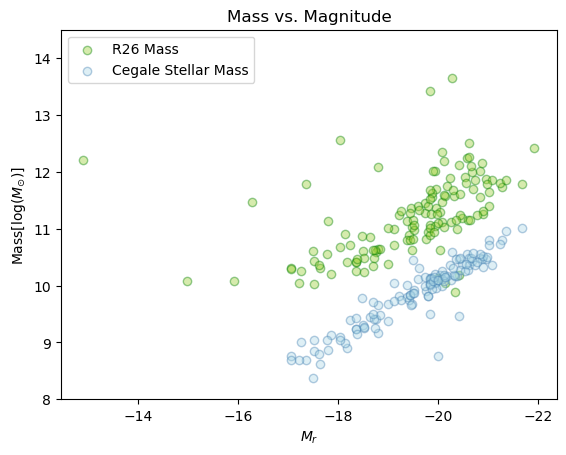

In [239]:
#total mass vs. cegale stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['RABS_MAG26']
z = sgas['M_STELLAR_CEGALE']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(w, z, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'cegale_stellar_total__mass_magplot.png', dpi=300)

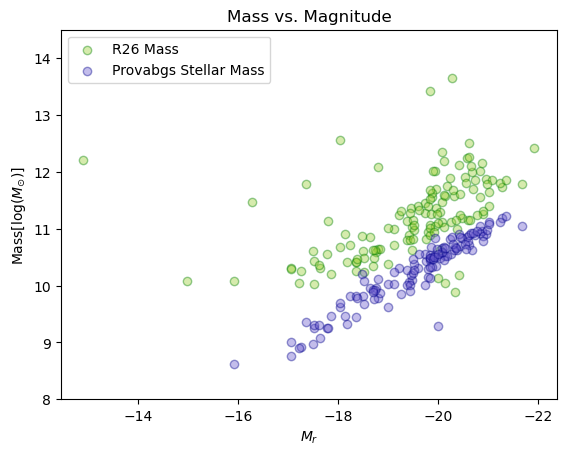

In [238]:
#total mass vs. provabgs stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
z = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_stellar_total__mass_magplot.png', dpi=300)

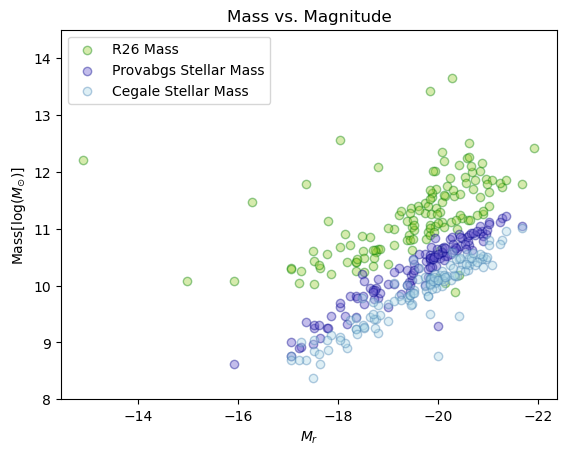

In [237]:
#total mass vs. provabgs stellar mass plotting each mass only once
#plotting
x = sgas['RABS_MAG26']
y = sgas['M_R26']
w = sgas['M_STELLAR_CEGALE']
z = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x, y, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass[$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'provabgs_stellar_total__mass_magplot.png', dpi=300)

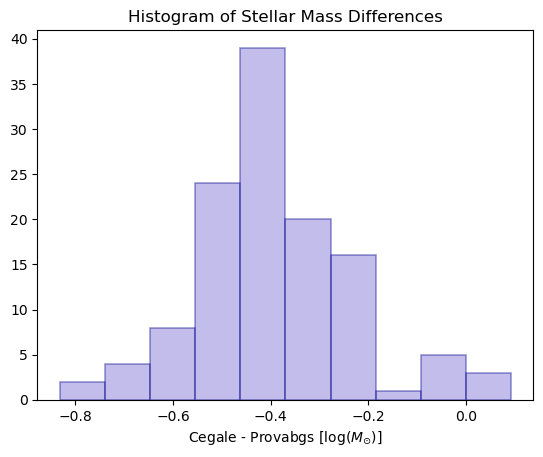

In [264]:
# Extracting stellar masses
m_stellar_cegale = sgas['M_STELLAR_CEGALE']
m_stellar_provabgs = sgas['M_STELLAR_PROVABGS']

# Calculating the difference
mass_difference = m_stellar_cegale - m_stellar_provabgs

# Plotting
plt.hist(mass_difference, bins=10,  color='slateblue', alpha = 0.4, edgecolor = 'darkblue', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"Cegale - Provabgs [$\log(M_{\odot})$]")
plt.title("Histogram of Stellar Mass Differences")

plt.savefig(v_dir + 'histogram_stellar_mass_difference.png', dpi=300)
plt.show()

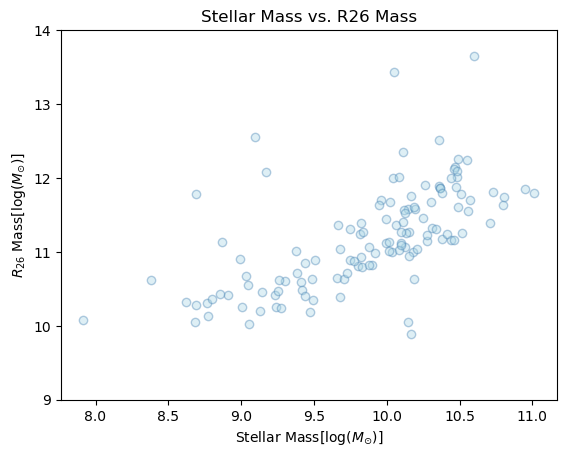

In [250]:
#stellar mass vs total mass R26 for cegale
#plotting
y = sgas['M_R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cegale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale')
plt.ylim(9, 14)
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.savefig(v_dir + 'cegale_stellar_r26__mass_plot.png', dpi=300)
plt.show()

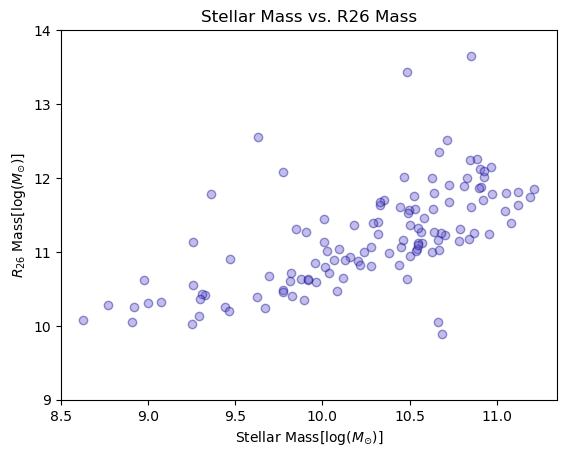

In [251]:
#stellar mass vs total mass R26 for provabgs
#plotting
y = sgas['M_R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(9, 14)
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.savefig(v_dir + 'provabgs_stellar_r26__mass_plot.png', dpi=300)
plt.show()

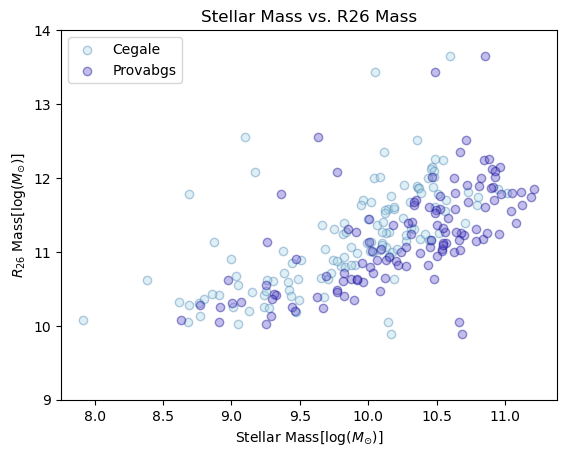

In [257]:
#stellar mass vs total mass R26 for both
#plotting
y = sgas['M_R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cegale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(9, 14)
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.legend()
plt.savefig(v_dir + 'stellar_total__mass_plot.png', dpi=300)
plt.show()

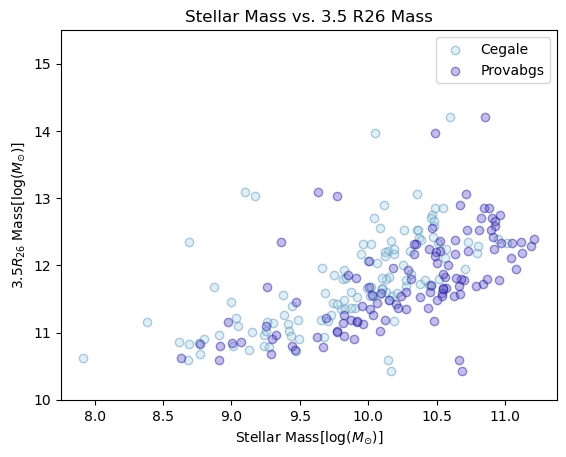

In [258]:
#stellar mass vs total mass 3.5 R26 for both
#plotting
y = sgas['M_3P5R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cegale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(10, 15.5)
plt.ylabel(r"$3.5 R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. 3.5 R26 Mass")
plt.legend()
plt.savefig(v_dir + 'stellar_3p5r26__mass_plot.png', dpi=300)
plt.show()

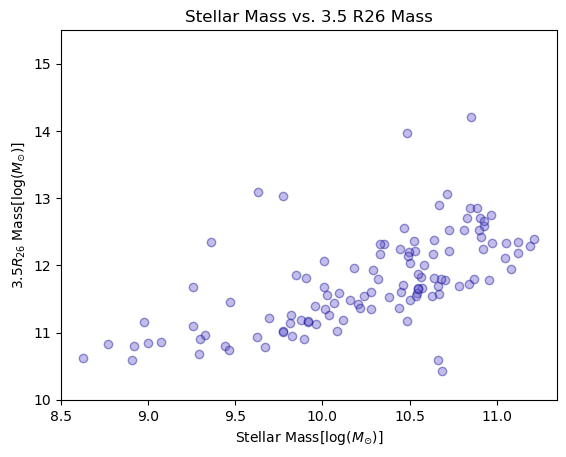

In [261]:
#stellar mass vs total mass 3.5 R26 for provabgs
#plotting
y = sgas['M_3P5R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
plt.ylim(10, 15.5)
plt.ylabel(r"$3.5 R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. 3.5 R26 Mass")
plt.savefig(v_dir + 'provabgs_stellar_3p5r26__mass_plot.png', dpi=300)
plt.show()

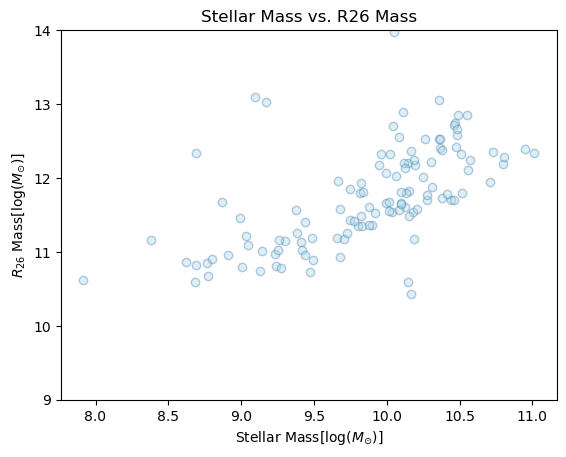

In [267]:
#stellar mass vs total mass 3.5 R26 for cegale
#plotting
y = sgas['M_3P5R26']
x_cegale = sgas['M_STELLAR_CEGALE']
x_provabgs = sgas['M_STELLAR_PROVABGS']
#plot
plt.scatter(x_cegale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cegale')
plt.ylim(9, 14)
plt.ylabel(r"$R_{26}$ Mass[$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass[$\log(M_{\odot})$]")
plt.title("Stellar Mass vs. R26 Mass")
plt.savefig(v_dir + 'cegale_stellar_3p5_r26__mass_plot.png', dpi=300)
plt.show()

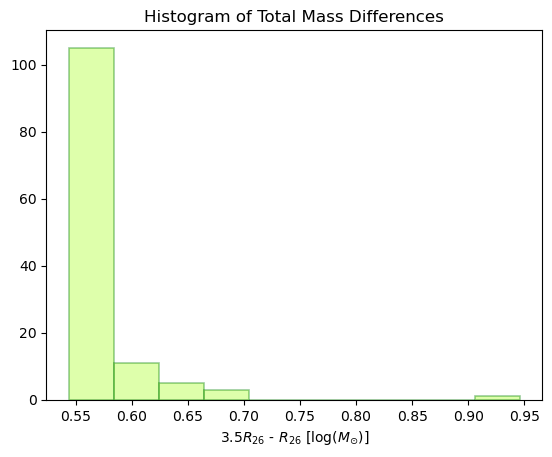

In [266]:
Histogram of total mass diffs
# Extracting stellar masses
m_r26 = sgas['M_R26']
m_3p5_r26 = sgas['M_3P5R26']

# Calculating the difference
mass_difference = m_3p5_r26 - m_r26

# Plotting
plt.hist(mass_difference, bins=10, color='greenyellow', alpha=0.4, edgecolor='green', linewidth=1.2, label='Mass Difference')

plt.xlabel(r"$3.5 R_{26}$ - $R_{26}$ [$\log(M_{\odot})$]")
plt.title("Histogram of Total Mass Differences")

plt.savefig(v_dir + 'histogram_total_mass_difference.png', dpi=300)
plt.show()

In [ ]:
#writing new data into new table
tf_mastertable.write(data_dir + 'tf_mastertable_massmag_stellar.fits', format='fits', overwrite=True)